# Importation des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import pickle
from pathlib import Path

# Matplotlib settings
from matplotlib import rcParams

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# TensorFlow & Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import Huber
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Custom PCA module
import pcax


2025-03-18 15:32:14.536753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Chargement et traitement des données test/validation

In [2]:
def load_data(file_path):
    data = np.load(file_path)
    spectres = np.log1p(data["simulations"])  # Log transform for stability
    theta = data["theta"]
    return spectres, theta

# Update with your own path
data_path = Path("/Users/xifumacbook/Documents/Codes/Spectres/diskbb/diskbb06-001-50.npz")
spectres, theta = load_data(data_path)

print(f"Theta shape: {theta.shape}")
print(f"Spectrum shape: {spectres.shape}")

# Extract temperature parameter and reshape
temperatures = theta[:, 0].reshape(-1, 1)

# =======================
# Apply Normalization using Spline
# =======================

# Load spline for normalization
spline_filename = data_path.with_suffix(".pkl")
with open(spline_filename, "rb") as f:
    spline_N = pickle.load(f)

# Function to get adjusted normalization
def get_norm_spline(T):
    return 10**spline_N(np.log10(T))

# =======================
# Split Data
# =======================

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    temperatures, spectres, test_size=0.1, random_state=42
)

# Scaling
spectre_scaler = StandardScaler()

y_train_scaled = spectre_scaler.fit_transform(y_train)
y_test_scaled = spectre_scaler.transform(y_test)

# =======================
# PCA Reduction
# =======================

n_PCA = 15
pca_state = pcax.fit(y_train_scaled, n_components=n_PCA)
y_train_pca = pcax.transform(pca_state, y_train_scaled)
y_test_pca = pcax.transform(pca_state, y_test_scaled)

explained_variance = np.sum(y_train_pca.var(axis=0)) / np.sum(y_train_scaled.var(axis=0))
print(f"Variance explained by first {n_PCA} components: {explained_variance:.4%}")

# # Save PCA state
# with open("diskbb_pca.pkl", "wb") as f:
#     pickle.dump(pca_state, f)

Theta shape: (100000, 2)
Spectrum shape: (100000, 10000)
Variance explained by first 15 components: 100.0000%


# Modèle BBNN

/Users/xifumacbook/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         2,415 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,167 (20.18 KB)

 Trainable params: 5,167 (20.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.2273 - val_loss: 0.5119 - learning_rate: 0.0051
Epoch 2/300
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3611 - val_loss: 0.1659 - learning_rate: 0.0051
Epoch 3/300
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1334 - val_loss: 0.0671 - learning_rate: 0.0051
Epoch 4/300
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0575 - val_loss: 0.0394 - learning_rate: 0.0051
Epoch 5/300
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0390 - val_loss: 0.0188 - learning_rate: 0.0051
Epoch 6/300
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0220 - val_loss: 0.0216 - learning_rate: 0.0051
Epoch 7/300
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0176 - val_loss: 0.0091 - learning_rate: 0.0051
Epoch 8/300
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0139 - val_loss: 0.0086 - learning_rate: 0.0051
Epoch 9/300
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099 - val_loss: 0.0192 - learn

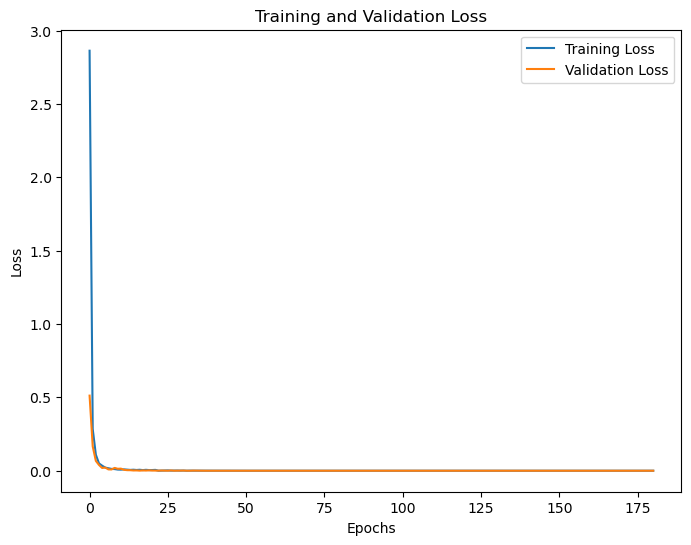

In [3]:
# =======================
# Model Building
# =======================

def BBNN(input_dim, output_dim, learning_rate=0.005058857837580419):
    model = Sequential([
        Dense(16, activation='gelu', input_dim=input_dim),
        Dense(160, activation='gelu'),
        Dense(output_dim, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=Huber(delta=1.35)
    )
    return model

input_dim = X_train.shape[1]
output_dim = n_PCA
model = BBNN(input_dim, output_dim)
model.summary()

# =======================
# Training
# =======================

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train_pca,
    validation_split=0.1,
    epochs=300,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# =======================
# Plotting Loss
# =======================

def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

plot_loss(history)

# model.save("diskbb_model.keras")


# Analyse - Plot de spectres et d'erreur

In [4]:
# =======================
# Plotting Spectra
# =======================

def plot_spectra(temperature):
    eps = 1e-8

    # Find the closest temperature index
    idx = (np.abs(temperatures - temperature)).argmin()
    true_spectrum = spectres[idx]

    # Prepare input for prediction
    temp_input = np.array([[temperature]])

    # Predict using the model
    pred_pca = model.predict(temp_input)
    pred_scaled = pcax.recover(pca_state, pred_pca)
    pred_spectrum = spectre_scaler.inverse_transform(pred_scaled).flatten()

    # Inverse log1p transformation + division par la spline
    true_spectrum = np.expm1(true_spectrum) / get_norm_spline(temperature)
    pred_spectrum = np.expm1(pred_spectrum) / get_norm_spline(temperature)

    # Calculate relative error per bin
    error_bin = (true_spectrum - pred_spectrum) / (np.abs(true_spectrum) + eps) * 100

    # Calculate global error
    global_error = 100 * np.linalg.norm(true_spectrum - pred_spectrum) / (np.linalg.norm(true_spectrum) + eps)
    print(f"T = {temperature:.3f} keV | Relative overall error: {global_error:.3f}%")

    # Energy scale
    energy_array = np.geomspace(0.01, 50, true_spectrum.shape[0])

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # Plot original and reconstructed spectra
    ax1.semilogx(energy_array, pred_spectrum, label='Reconstructed Spectrum', color='blue')
    ax1.semilogx(energy_array, true_spectrum, label='Original Spectrum', color='red', linestyle='dashed')
    ax1.set_xlabel("Energy (keV)")
    ax1.set_ylabel("Intensity")
    ax1.legend()

    # Plot relative error
    ax2.plot(energy_array, error_bin, label="Relative Error (%)", color='red')
    ax2.fill_between(energy_array, 0, error_bin, color='red', alpha=0.3)
    ax2.set_xlabel("Energy (keV)")
    ax2.set_ylabel("Error (%)")
    ax2.legend()

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
T = 0.010 keV | Relative overall error: 0.000%


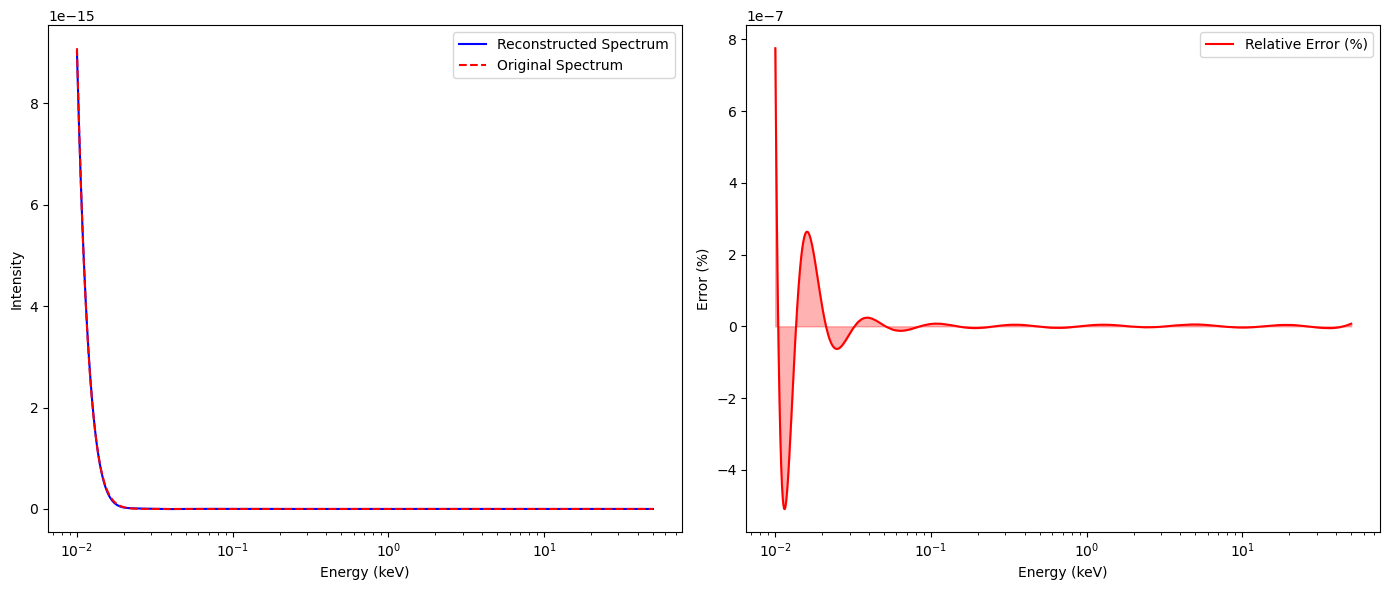

In [5]:
plot_spectra(0.01)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


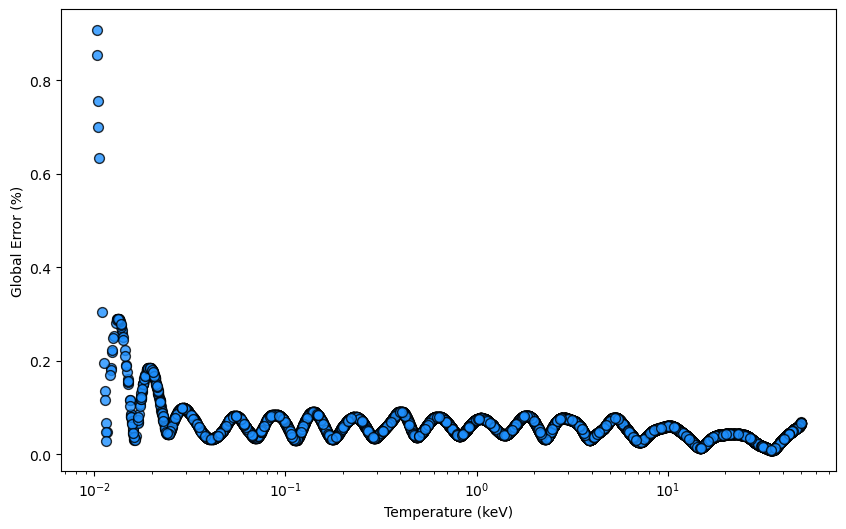

In [6]:
def plot_global_errors():
    eps = 1e-8

    # Predict on test set
    y_pred_pca = model.predict(X_test)
    y_pred_scaled = pcax.recover(pca_state, y_pred_pca)
    y_pred = spectre_scaler.inverse_transform(y_pred_scaled) 

    # De-normalize test data
    y_test_original = spectre_scaler.inverse_transform(y_test_scaled)

    

    # Initialize list for global errors
    global_errors = []
    temperatures_test = X_test.flatten()

    # Calculate global error for each spectrum
    for true_spectrum, pred_spectrum in zip(np.expm1(y_test_original), np.expm1(y_pred)):
        global_error = 100 * np.linalg.norm(true_spectrum - pred_spectrum) / (np.linalg.norm(true_spectrum) + eps)
        global_errors.append(global_error)

    # Plot global errors
    plt.figure(figsize=(10, 6))
    plt.scatter(temperatures_test, global_errors, color='dodgerblue', alpha=0.8, edgecolor='black', s=50)
    plt.xscale('log')
    plt.xlabel('Temperature (keV)')
    plt.ylabel('Global Error (%)')
    plt.show()

plot_global_errors()

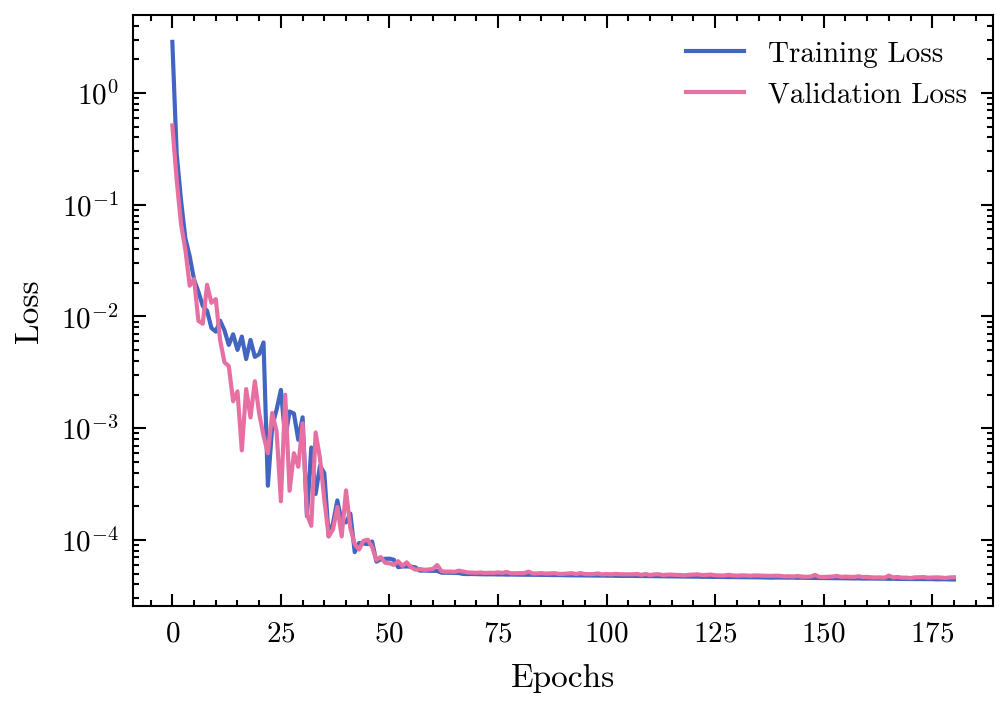

In [25]:
import scienceplots

def plot_loss2(history):
    # Appliquer le style scientifique sans LaTeX
    plt.style.use(['science', 'no-latex', 'retro'])
    
    # Paramètres RC pour un rendu IEEE
    rcParams['figure.figsize'] = (3.5, 2.5)  # Taille du plot en pouces
    rcParams['figure.dpi'] = 300             # Haute résolution
    rcParams['font.size'] = 8                # Taille des polices
    rcParams['axes.titlesize'] = 8           # Taille du titre des axes
    rcParams['axes.labelsize'] = 8           # Taille des labels des axes
    rcParams['xtick.labelsize'] = 7          # Taille des ticks sur l'axe X
    rcParams['ytick.labelsize'] = 7          # Taille des ticks sur l'axe Y
    rcParams['legend.fontsize'] = 7          # Taille de la légende
    rcParams['lines.linewidth'] = 1.0        # Épaisseur des courbes
    rcParams['grid.linewidth'] = 0.5         # Épaisseur des lignes de la grille
    
    # Création du graphique
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()  # Ajustement automatique des marges
    plt.show()

plot_loss2(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


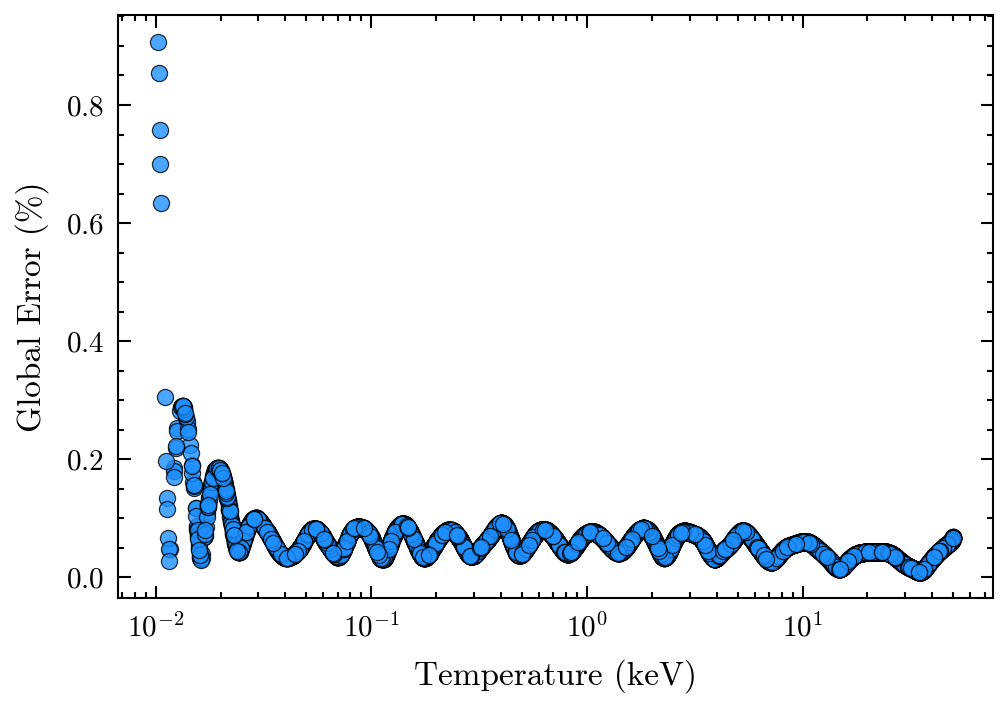

In [8]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

def plot_global_errors():
    eps = 1e-8

    # Appliquer le style scientifique sans LaTeX
    plt.style.use(['science', 'no-latex', 'scatter'])

    # Paramètres RC pour un rendu IEEE
    rcParams['figure.figsize'] = (3.5, 2.5)  # Taille du plot en pouces
    rcParams['figure.dpi'] = 300             # Haute résolution
    rcParams['font.size'] = 8                # Taille des polices
    rcParams['axes.titlesize'] = 8           # Taille du titre des axes
    rcParams['axes.labelsize'] = 8           # Taille des labels des axes
    rcParams['xtick.labelsize'] = 7          # Taille des ticks sur l'axe X
    rcParams['ytick.labelsize'] = 7          # Taille des ticks sur l'axe Y
    rcParams['legend.fontsize'] = 7          # Taille de la légende
    rcParams['lines.linewidth'] = 1.0        # Épaisseur des courbes
    rcParams['grid.linewidth'] = 0.5         # Épaisseur des lignes de la grille

    # Prédiction sur l'ensemble de test
    y_pred_pca = model.predict(X_test)
    y_pred_scaled = pcax.recover(pca_state, y_pred_pca)
    y_pred = spectre_scaler.inverse_transform(y_pred_scaled) 

    # Dé-normalisation des données de test
    y_test_original = spectre_scaler.inverse_transform(y_test_scaled)

    # Calcul des erreurs globales
    global_errors = []
    temperatures_test = X_test.flatten()

    for true_spectrum, pred_spectrum in zip(np.expm1(y_test_original), np.expm1(y_pred)):
        global_error = 100 * np.linalg.norm(true_spectrum - pred_spectrum) / (np.linalg.norm(true_spectrum) + eps)
        global_errors.append(global_error)

    # Tracer les erreurs globales
    plt.figure()
    plt.scatter(temperatures_test, global_errors, color='dodgerblue', alpha=0.8, edgecolor='black', s=15, linewidth=0.3)
    plt.xscale('log')
    plt.xlabel('Temperature (keV)')
    plt.ylabel('Global Error (%)')

    plt.tight_layout()  # Ajustement automatique de la mise en page
    plt.show()

# Exemple d'utilisation
plot_global_errors()


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

def plot_spectra2(temperature):
    eps = 1e-8

    # Appliquer le style scientifique sans LaTeX
    plt.style.use(['science', 'no-latex'])

    # Paramètres RC pour un rendu IEEE
    rcParams['figure.figsize'] = (3.5, 2.5)  # Taille du plot en pouces
    rcParams['figure.dpi'] = 300             # Haute résolution
    rcParams['font.size'] = 8                # Taille des polices
    rcParams['axes.titlesize'] = 8           # Taille du titre des axes
    rcParams['axes.labelsize'] = 8           # Taille des labels des axes
    rcParams['xtick.labelsize'] = 7          # Taille des ticks sur l'axe X
    rcParams['ytick.labelsize'] = 7          # Taille des ticks sur l'axe Y
    rcParams['legend.fontsize'] = 7          # Taille de la légende
    rcParams['lines.linewidth'] = 1.0        # Épaisseur des courbes
    rcParams['grid.linewidth'] = 0.5         # Épaisseur des lignes de la grille

    # Trouver l'index le plus proche pour la température
    idx = (np.abs(temperatures - temperature)).argmin()
    true_spectrum = spectres[idx]

    # Préparer l'entrée pour la prédiction
    temp_input = np.array([[temperature]])
    pred_pca = model.predict(temp_input)
    pred_scaled = pcax.recover(pca_state, pred_pca)
    pred_spectrum = spectre_scaler.inverse_transform(pred_scaled).flatten()

    # Transformation inverse log1p + normalisation
    true_spectrum = np.expm1(true_spectrum) / get_norm_spline(temperature)
    pred_spectrum = np.expm1(pred_spectrum) / get_norm_spline(temperature)

    # Calcul de l'erreur relative par bin
    error_bin = (true_spectrum - pred_spectrum) / (np.abs(true_spectrum) + eps) * 100

    # Calcul de l'erreur globale
    global_error = 100 * np.linalg.norm(true_spectrum - pred_spectrum) / (np.linalg.norm(true_spectrum) + eps)
    print(f"T = {temperature:.3f} keV | Relative overall error: {global_error:.3f}%")

    # Échelle d'énergie
    energy_array = np.geomspace(0.01, 50, true_spectrum.shape[0])

    # Création des sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharex=True)  # Ajustement taille IEEE

    # Tracer le spectre original et reconstruit
    ax1.semilogx(energy_array, pred_spectrum, label='Reconstructed Spectrum', color='blue')
    ax1.semilogx(energy_array, true_spectrum, label='Original Spectrum', color='red', linestyle='dashed')
    ax1.set_xlabel("Energy (keV)")
    ax1.set_ylabel("Intensity")
    ax1.legend()


    # Tracer l'erreur relative
    ax2.plot(energy_array, error_bin, label="Relative Error (%)", color='red')
    ax2.fill_between(energy_array, 0, error_bin, color='red', alpha=0.3)
    ax2.set_xlabel("Energy (keV)")
    ax2.set_ylabel("Error (%)")
    ax2.legend()

    # Ajustement automatique de la mise en page
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
T = 17.000 keV | Relative overall error: 0.034%


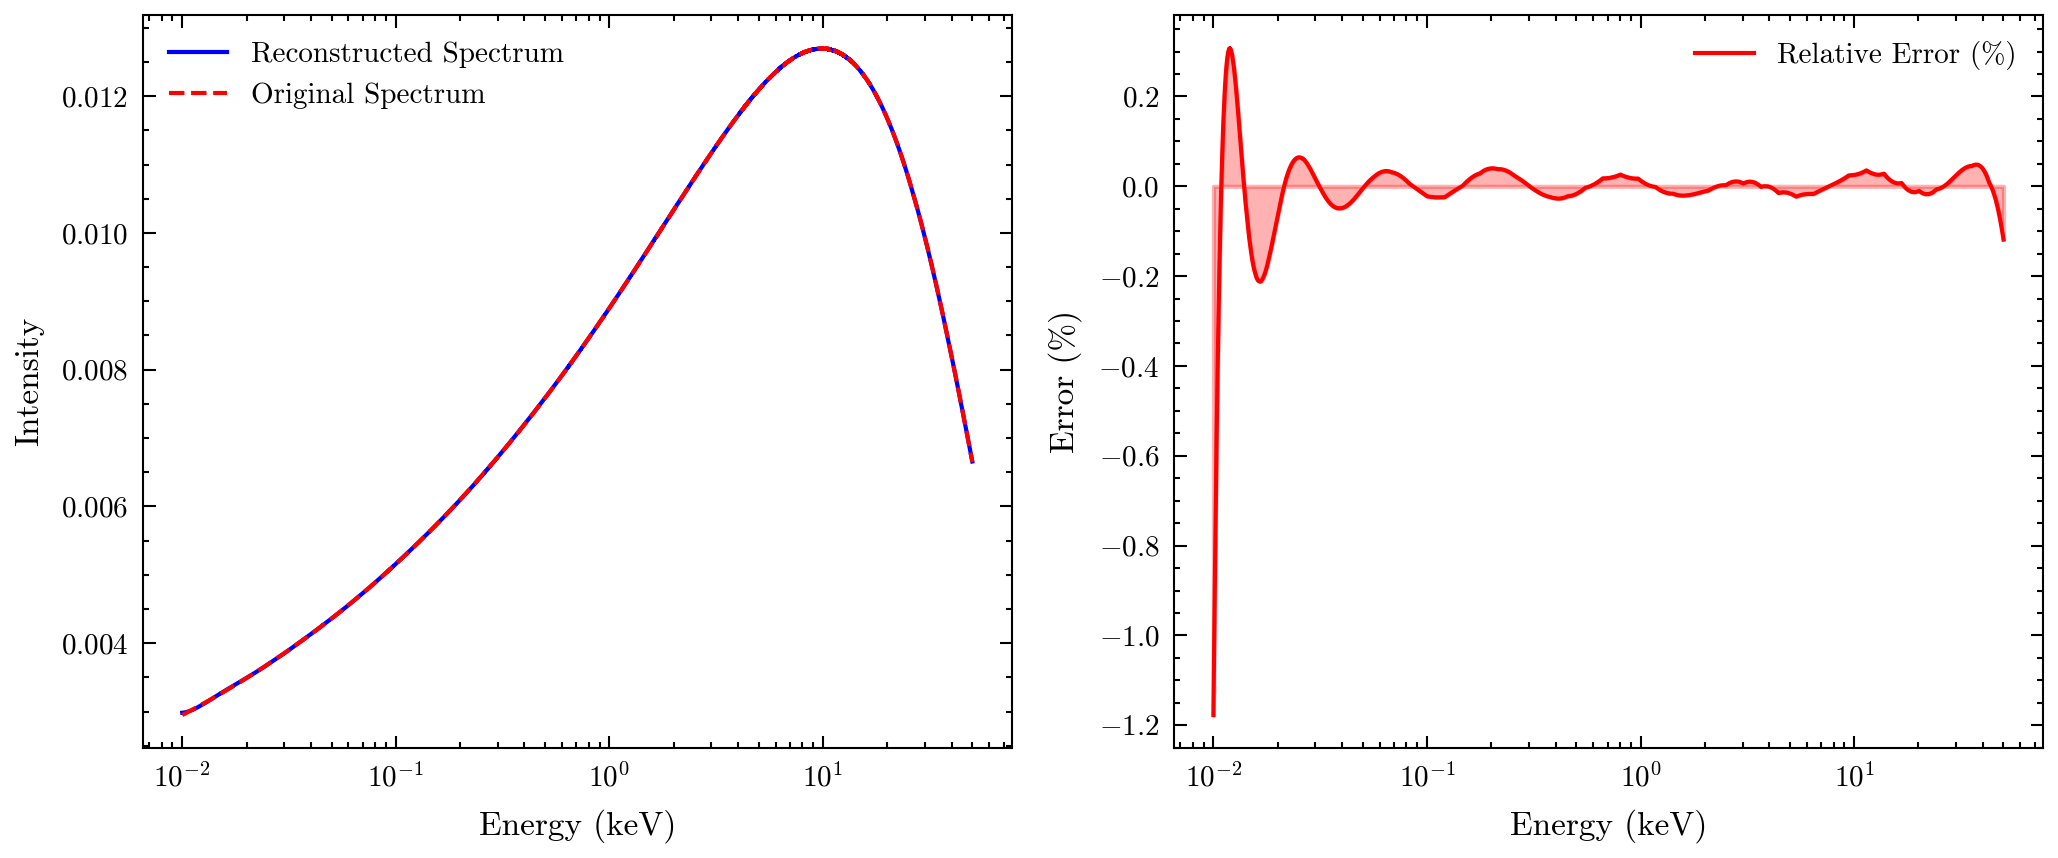

In [35]:
plot_spectra2(17)